In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score,\
                            f1_score, roc_auc_score, roc_curve, auc, accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, MaxPooling1D, Conv1D


from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import backend as K
import tensorflow as tf
import itertools

from time import time

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Project Deep Learning/training.csv',delimiter=',')
df_test = pd.read_csv('/content/drive/MyDrive/Project Deep Learning/testing.csv',delimiter=',')

In [ ]:
# Display distinct value in each columns
print("\n")
print("Number of unique value in training data")
for col in df.columns:
  nb_valeurs = len(pd.unique(df[col]))
  print( "{} : {} valeurs".format(col,nb_valeurs) )

# Check if our data set contain non null values
print("\n")
print("Nomber of NaN per column")
for col in df.columns:
  nb_valeurs = df[col].isna().sum()
  print( "{} : {} NaN".format(col,nb_valeurs) )

In [ ]:
label_balance = df["label"].value_counts()
print('Normal: {:8d} flows {:8.3f} %'.format(label_balance[0], 100*label_balance[0]/df.shape[0]))
print('Attack: {:8d} flows {:8.3f} %'.format(label_balance[1], 100*label_balance[1]/df.shape[0]))

Normal:    56000 flows   31.938 %
Attack:   119341 flows   68.062 %


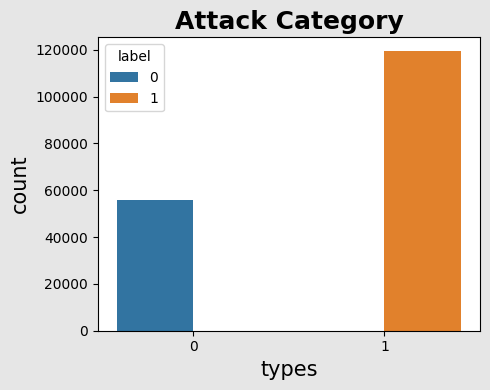

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#Classification of traffic into two subcategories

f, axs = plt.subplots(figsize=(5,4))
ax = sns.countplot(x='label', hue='label', data=df)
ax.set_title('Attack Category', fontsize=18, fontweight='bold', color='black')
ax.set_xlabel('types', fontsize=15, color='black')
ax.set_ylabel('count', fontsize=15, color='black')
ax.figure.set_facecolor('0.9')

plt.tight_layout()
plt.show()

In [ ]:
df.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'label'],
      dtype='object')

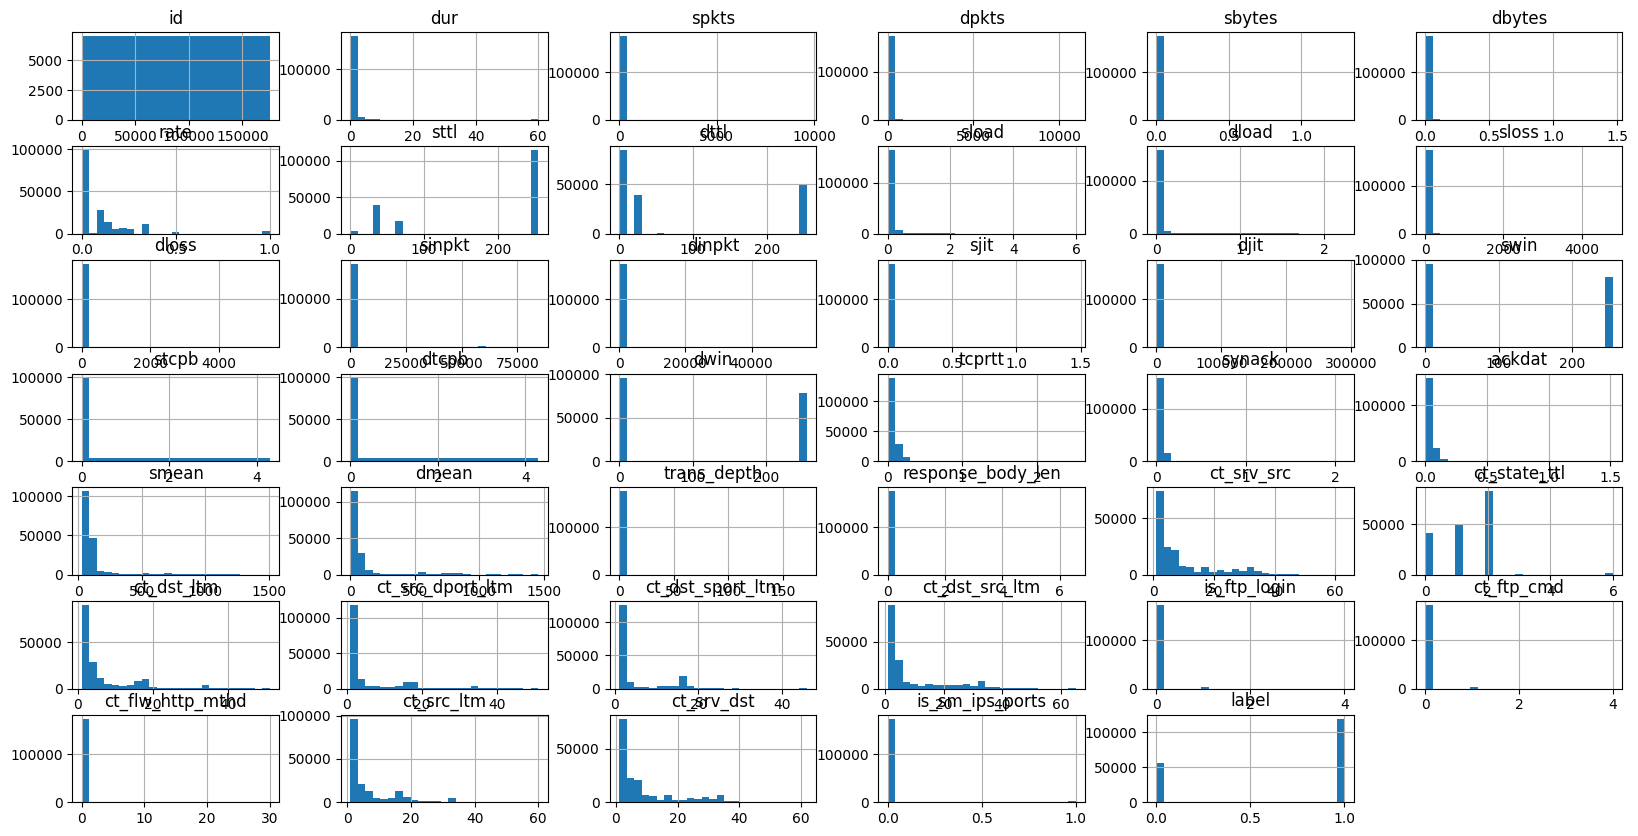

In [ ]:
df.hist(bins=25,figsize=(20,10));

In [3]:
# Let`s drop column named id and attack_cat as there not usefull 
df.drop(labels=['attack_cat', 'id'], axis=1, inplace=True)

In [4]:
# Let`s remove the hyphen present in the "service" feature column
df['service'].unique()
df['service']= np.where(df['service'] == '-', 'None', df['service'])

print("\n")
print(df['service'].unique())



['None' 'ftp' 'smtp' 'snmp' 'http' 'ftp-data' 'dns' 'ssh' 'radius' 'pop3'
 'dhcp' 'ssl' 'irc']


In [5]:
# let's extract the numerics columns for normalization
numeric_cols = ['dur', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports']

In [6]:
import matplotlib.gridspec as gridspec 
def plot_hist(df, cols, title):
    grid = gridspec.GridSpec(20, 3, wspace=0.5, hspace=0.5) 
    fig = plt.figure(figsize=(15,25)) 
    
    for n, col in enumerate(df[cols]):         
        ax = plt.subplot(grid[n]) 

        ax.hist(df[col], bins=20) 
        #ax.set_ylabel('Count', fontsize=12)
        ax.set_title(f'{col} distribution', fontsize=15) 
    fig.suptitle(title, fontsize=20)
    grid.tight_layout(fig, rect=[0, 0, 1, 0.97])
    plt.show()

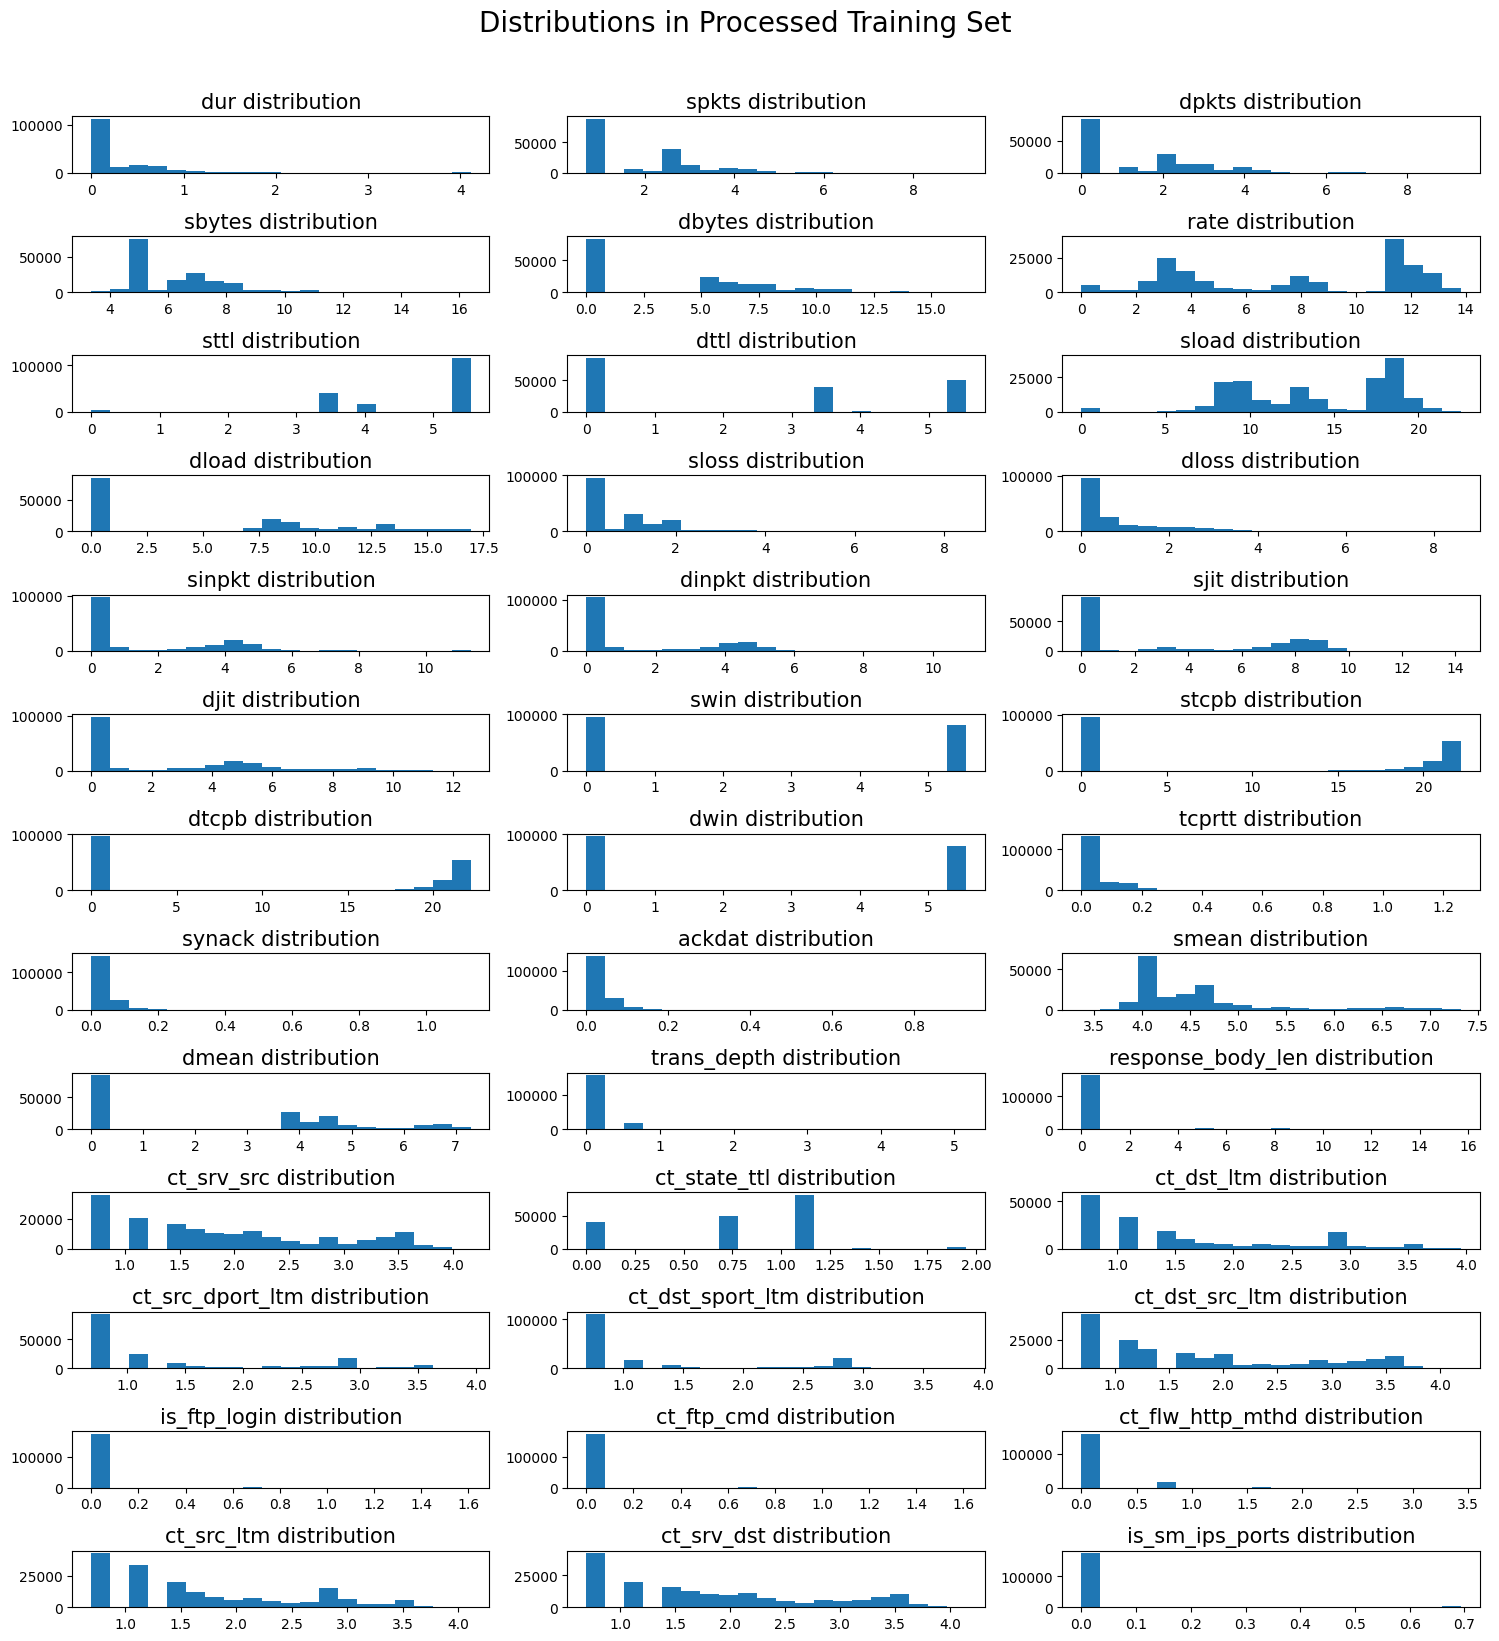

In [7]:
for col in numeric_cols:
    df[col] = np.log1p(df[col])
    
plot_hist(df, numeric_cols, 'Distributions in Processed Training Set')

In [ ]:
corr=df[numeric_cols].corr(method='pearson')

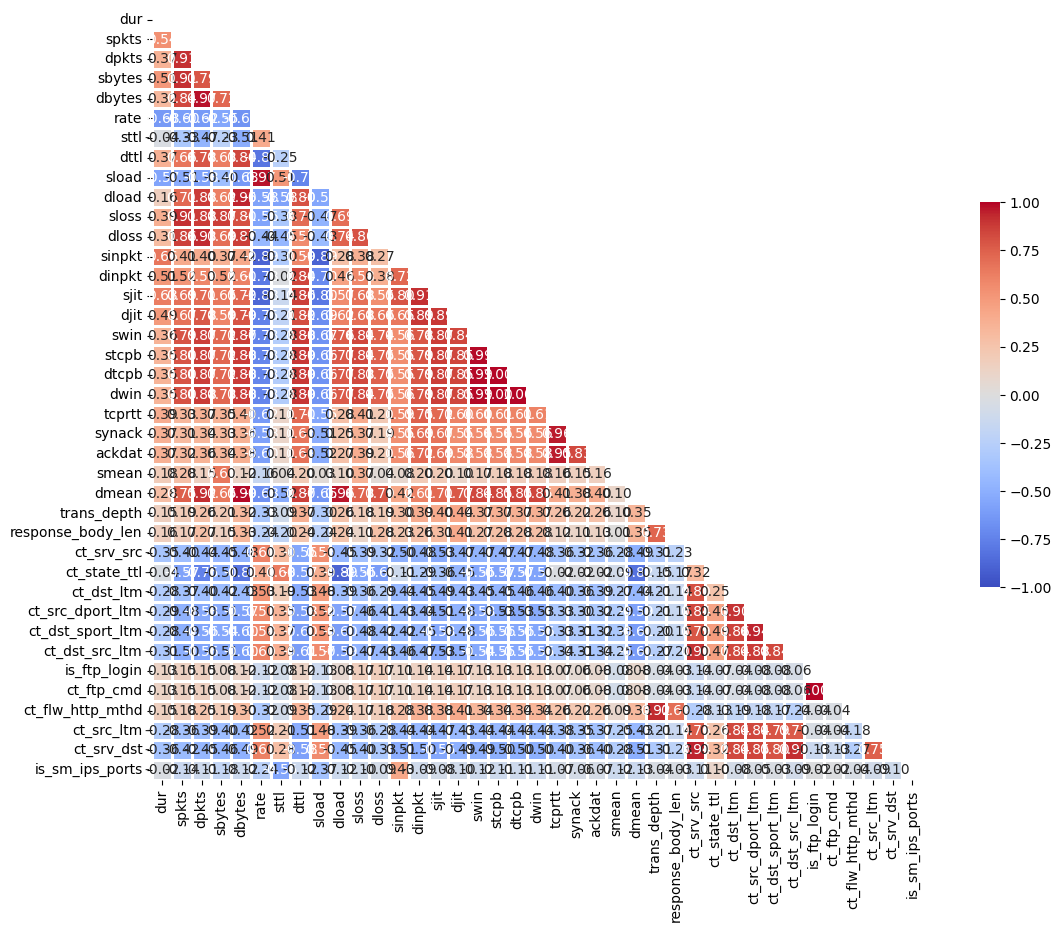

In [ ]:
plt.figure(figsize=(15, 10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns, 
            cmap="coolwarm", 
            annot=True, 
            fmt=".2f",
            mask=mask, 
            vmax=1, 
            vmin=-1,
            center=0,
            square=True, 
            linewidths=1, 
            cbar_kws={"shrink": .5})
plt.show()

In [ ]:
X = df[numeric_cols]
all_outliers = np.array([])
for feature in numeric_cols:
    Q1 = X[feature].quantile(.25)
    Q3 = X[feature].quantile(.75)
    IQR = float(Q3) - float(Q1)
    outliers = X[((X[feature] <= Q1 - 1.5 * IQR)
                  & (X[feature] >= Q3 + 1.5 * IQR))]
    all_outliers = np.append(all_outliers, np.array(outliers.index.values.tolist()).astype(int))
outlier_count = np.count_nonzero(np.unique(all_outliers))
print('{} outliers were identified, over {} datapoints, which represents {} %.'
      .format(outlier_count,
              df.shape[0],
              round(outlier_count/df.shape[0] * 100, 2)
             )
     )

175340 outliers were identified, over 175341 datapoints, which represents 100.0 %.


In [8]:
# let`s scale our numeric features using Min-Max scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

for i in numeric_cols:
  scaler = MinMaxScaler()
  df[i] = scaler.fit_transform(df[[i]])

In [9]:
# let`s scale our Categorical features using standard scaler
from sklearn.preprocessing import LabelEncoder
cat_data = ['state', 'service','proto']
le = LabelEncoder()
for col in cat_data:
    df[col]=le.fit_transform(df[col])
    print(le.classes_)

['CON' 'ECO' 'FIN' 'INT' 'PAR' 'REQ' 'RST' 'URN' 'no']
['None' 'dhcp' 'dns' 'ftp' 'ftp-data' 'http' 'irc' 'pop3' 'radius' 'smtp'
 'snmp' 'ssh' 'ssl']
['3pc' 'a/n' 'aes-sp3-d' 'any' 'argus' 'aris' 'arp' 'ax.25' 'bbn-rcc'
 'bna' 'br-sat-mon' 'cbt' 'cftp' 'chaos' 'compaq-peer' 'cphb' 'cpnx'
 'crtp' 'crudp' 'dcn' 'ddp' 'ddx' 'dgp' 'egp' 'eigrp' 'emcon' 'encap'
 'etherip' 'fc' 'fire' 'ggp' 'gmtp' 'gre' 'hmp' 'i-nlsp' 'iatp' 'ib'
 'icmp' 'idpr' 'idpr-cmtp' 'idrp' 'ifmp' 'igmp' 'igp' 'il' 'ip' 'ipcomp'
 'ipcv' 'ipip' 'iplt' 'ipnip' 'ippc' 'ipv6' 'ipv6-frag' 'ipv6-no'
 'ipv6-opts' 'ipv6-route' 'ipx-n-ip' 'irtp' 'isis' 'iso-ip' 'iso-tp4'
 'kryptolan' 'l2tp' 'larp' 'leaf-1' 'leaf-2' 'merit-inp' 'mfe-nsp' 'mhrp'
 'micp' 'mobile' 'mtp' 'mux' 'narp' 'netblt' 'nsfnet-igp' 'nvp' 'ospf'
 'pgm' 'pim' 'pipe' 'pnni' 'pri-enc' 'prm' 'ptp' 'pup' 'pvp' 'qnx' 'rdp'
 'rsvp' 'rtp' 'rvd' 'sat-expak' 'sat-mon' 'sccopmce' 'scps' 'sctp' 'sdrp'
 'secure-vmtp' 'sep' 'skip' 'sm' 'smp' 'snp' 'sprite-rpc' 'sps' 'srp'
 

In [10]:
all_col = ['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports']

Here is what the transformed features of the dataset look like


In [ ]:
df[numeric_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
dur,175341.0,0.082358,0.159209,0.0,0.000002,0.000385,0.124467,1.0
spkts,175341.0,0.156985,0.135001,0.0,0.047825,0.047825,0.220780,1.0
dpkts,175341.0,0.149594,0.166843,0.0,0.000000,0.118087,0.257745,1.0
sbytes,175341.0,0.224488,0.127265,0.0,0.105887,0.207434,0.299021,1.0
dbytes,175341.0,0.232077,0.240119,0.0,0.000000,0.309445,0.424585,1.0
rate,175341.0,0.568704,0.300595,0.0,0.254790,0.584795,0.849486,1.0
sttl,175341.0,0.870993,0.199597,0.0,0.747160,0.999294,0.999294,1.0
dttl,175341.0,0.430217,0.436384,0.0,0.000000,0.613795,0.998579,1.0
sload,175341.0,0.618720,0.207209,0.0,0.420951,0.607973,0.812992,1.0
dload,175341.0,0.332037,0.342576,0.0,0.000000,0.429997,0.604673,1.0


# Dimensionality reduction with Principal Component Analysis and t-SNE

In [ ]:
pca = PCA(n_components=42)
df_projected = pca.fit_transform(df[all_col])

pcs = ['PC {}'.format(i) for i in range(1, len(pca.components_) + 1)]

ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)

variance_ratios = pd.DataFrame(np.round(ratios, 4), columns=['Explained Variance'])
variance_ratios.index = pcs
variance_ratios['Cumulative Variance'] = variance_ratios['Explained Variance'].cumsum(axis=0)

print(variance_ratios)

       Explained Variance  Cumulative Variance
PC 1               0.9835               0.9835
PC 2               0.0106               0.9941
PC 3               0.0037               0.9978
PC 4               0.0011               0.9989
PC 5               0.0005               0.9994
PC 6               0.0002               0.9996
PC 7               0.0001               0.9997
PC 8               0.0001               0.9998
PC 9               0.0001               0.9999
PC 10              0.0000               0.9999
PC 11              0.0000               0.9999
PC 12              0.0000               0.9999
PC 13              0.0000               0.9999
PC 14              0.0000               0.9999
PC 15              0.0000               0.9999
PC 16              0.0000               0.9999
PC 17              0.0000               0.9999
PC 18              0.0000               0.9999
PC 19              0.0000               0.9999
PC 20              0.0000               0.9999
PC 21        

We try to visualize the two first principal components, which represent about 98% of the variance

In [ ]:
pcaselect_df = pd.DataFrame(data=df_projected[:,:2], columns=[pcs[:2]])

pcaselect_labelled_df = pd.concat([pcaselect_df, df['label']], axis=1, ignore_index=True)
pcaselect_labelled_df.columns = [*pcs[:2], 'label']

In [ ]:
df_normal = pcaselect_labelled_df[pcaselect_labelled_df['label'] == 0]
df_malicious  = pcaselect_labelled_df[pcaselect_labelled_df['label'] == 1].sample(60000)

df_new = df_normal.append(df_malicious).sample(frac=1)
X = df_new[pcs[:2]].values
y = df_new['label'].values

<ipython-input-22-0777da2eb83d>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_normal.append(df_malicious).sample(frac=1)


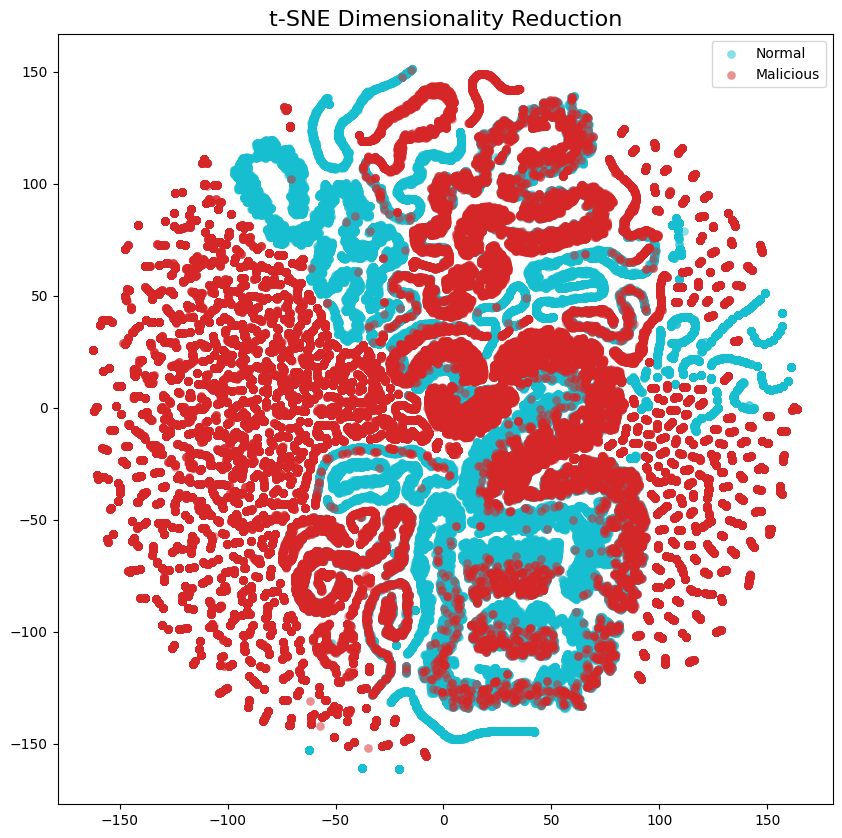

In [ ]:
tsne = TSNE(n_components=2, random_state=37)
X_transformed = tsne.fit_transform(X)


plt.figure(figsize=(10, 10))
plt.title("t-SNE Dimensionality Reduction", fontsize = 16)
plt.scatter(X_transformed[y == 0, 0], X_transformed[y == 0, 1], label="Normal", alpha=0.5, linewidth=0.15, c='#17becf')
plt.scatter(X_transformed[y == 1, 0], X_transformed[y == 1, 1], label="Malicious", alpha=0.5, linewidth=0.15, c='#d62728')
plt.legend()
plt.show()


The above graph shows that normal and malicious network flows are not overall clearly separated into two different clusters in the two-dimensional space.

# Hyperparameter Tunning and features selection

Test for feature importance

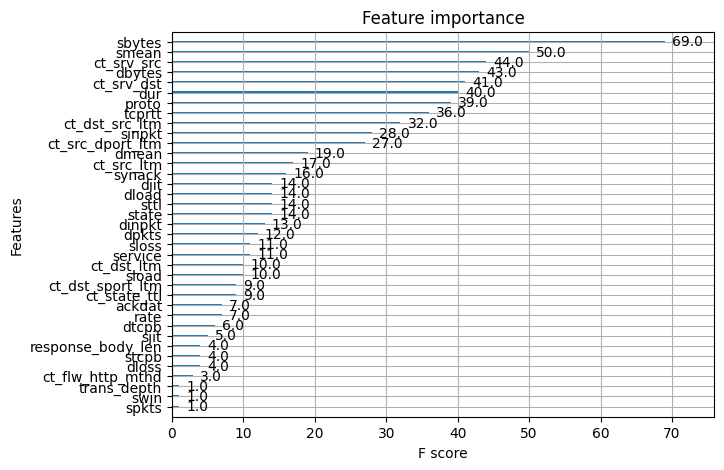

Important features: ['state', 'sbytes', 'sttl', 'sloss', 'sinpkt', 'synack', 'smean', 'dmean', 'trans_depth', 'ct_dst_src_ltm', 'ct_srv_dst']


In [11]:
import xgboost as xgb
import matplotlib.pyplot as plt

# First train and label data created. 
train_data, label_data = df.iloc[:,:-1], df.iloc[:,-1]

# load data
data = xgb.DMatrix(train_data, label=label_data)

# set parameters
params = {'max_depth': 8, 'eta': 0.1, 'objective': 'binary:logistic'}

# train model
model = xgb.train(params, data)

# plot feature importance

plt.rcParams['figure.figsize'] = [7, 5]
xgb.plot_importance(model)
plt.show()


# set a threshold value for feature importance
threshold = 0.1

# get feature importance scores
importance_scores = model.get_score(importance_type='gain')

# calculate the average feature importance score
average_importance = sum(importance_scores.values()) / len(importance_scores)

# calculate the threshold value
importance_threshold = average_importance * threshold

# get the features whose importance scores are above the threshold
important_features = [feature for feature, score in importance_scores.items() if score >= importance_threshold]

# print the important features


print('Important features:', important_features)


In [12]:
Important_features = ['state', 'sbytes', 'sttl', 'sloss', 'sinpkt', 'synack', 'smean', 'dmean', 'trans_depth', 'ct_dst_src_ltm', 'ct_srv_dst']
df = df[Important_features]
df_model = pd.concat([df, label_data], axis=1)
df_test = df[Important_features]
test_model = pd.concat([df_test, label_data], axis=1)

In [14]:
df_final = df_model.copy()

In [ ]:
df_final

,state,sbytes,sttl,sloss,sinpkt,synack,smean,dmean,trans_depth,ct_dst_src_ltm,ct_srv_dst,label
0,2,0.168290,0.997874,0.000000,0.284813,0.000000,0.105563,0.519413,0.0,0.000000,0.000000,0
1,2,0.248459,0.747160,0.129596,0.346483,0.000000,0.152686,0.962103,0.0,0.115963,0.363121,0
2,2,0.194658,0.747160,0.081766,0.480517,0.052711,0.122264,0.921746,0.0,0.198240,0.363121,0
3,2,0.236489,0.747160,0.081766,0.443988,0.000000,0.152686,0.572971,0.0,0.198240,0.000000,0
4,2,0.224048,0.999294,0.129596,0.342653,0.060742,0.157419,0.525515,0.0,0.863841,0.868331,0
...,...,...,...,...,...,...,...,...,...,...,...,...
175336,3,0.105887,0.999294,0.000000,0.000790,0.000000,0.175514,0.000000,0.0,0.722358,0.732098,1
175337,2,0.235505,0.999294,0.129596,0.353926,0.032020,0.196452,0.522498,0.0,0.115963,0.000000,1
175338,3,0.105887,0.999294,0.000000,0.000790,0.000000,0.175514,0.000000,0.0,0.556530,0.542553,1
175339,3,0.105887,0.999294,0.000000,0.000790,0.000000,0.175514,0.000000,0.0,0.783879,0.794449,1


# Undersampling

In [15]:
data_us_malicious = df_final[df_final['label'] == 1].sample(80000)
data_us_normal = df_final[df_final['label'] == 0]
#data_us = data_us_malicious.append(data_us_normal, ignore_index=True)
data_us = pd.concat([data_us_malicious, data_us_normal], axis=0)

# Splitting the dataset into training and test. 

In [16]:
model_train, model_label = data_us.iloc[:,:-1], data_us.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(model_train, model_label, test_size=0.3, random_state=37)
#y_train = np.array(y_train).reshape(-1, 1)

# DNN model

We use early stop to prevent overfitting

In [17]:
from keras.callbacks import EarlyStopping

# Define early stopping callback

early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [23]:
from keras.layers import Input, Dense, Dropout
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.initializers import RandomUniform
from keras.initializers import glorot_uniform
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.layers import BatchNormalization


initializer = glorot_uniform(seed=123)


input_size = X_train.shape[1]

# Define the model architecture
input_block = tf.keras.Input(shape=(input_size))
output = tf.keras.layers.Dense(512, activation="relu",  kernel_initializer='he_normal')(input_block)
BatchNormalization()
output = tf.keras.layers.Dense(1024, activation="relu",  kernel_initializer='he_normal')(output)
BatchNormalization()
output = tf.keras.layers.Dense(2048, activation="relu",  kernel_initializer='he_normal')(output)
output = tf.keras.layers.Dense(1024, activation="relu",  kernel_initializer='he_normal')(output)
BatchNormalization()
output = tf.keras.layers.Dense(512, activation="relu",  kernel_initializer='he_normal')(output)
BatchNormalization()
output = tf.keras.layers.Dense(2, activation="sigmoid", kernel_initializer='he_normal')(output)

model = Model(input_block, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense (Dense)               (None, 512)               6144      
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 2048)              2099200   
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 2)                 1026  

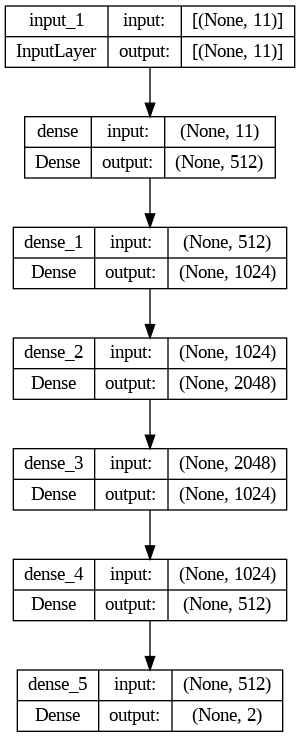

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file= 'model_dnn.png', show_shapes=True)

Save the model

In [ ]:
# Save the model to a file
model.save('modeldnnn.h5')

In [24]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
              )

Fit the model

In [25]:
history = model.fit(
    X_train, y_train,
    epochs=100, 
    batch_size=64,
    validation_data = (X_test, y_test),
    verbose=1)

Epoch 1/100
1488/1488 [==============================] - 9s 4ms/step - loss: 0.2032 - accuracy: 0.9156 - val_loss: 0.1575 - val_accuracy: 0.9250
Epoch 2/100
1488/1488 [==============================] - 6s 4ms/step - loss: 0.1522 - accuracy: 0.9282 - val_loss: 0.1443 - val_accuracy: 0.9312
Epoch 3/100
1488/1488 [==============================] - 6s 4ms/step - loss: 0.1429 - accuracy: 0.9320 - val_loss: 0.1386 - val_accuracy: 0.9328
Epoch 4/100
1488/1488 [==============================] - 6s 4ms/step - loss: 0.1382 - accuracy: 0.9337 - val_loss: 0.1494 - val_accuracy: 0.9302
Epoch 5/100
1488/1488 [==============================] - 6s 4ms/step - loss: 0.1337 - accuracy: 0.9368 - val_loss: 0.1348 - val_accuracy: 0.9340
Epoch 6/100
1488/1488 [==============================] - 6s 4ms/step - loss: 0.1341 - accuracy: 0.9364 - val_loss: 0.1336 - val_accuracy: 0.9361
Epoch 7/100
1488/1488 [==============================] - 6s 4ms/step - loss: 0.1304 - accuracy: 0.9378 - val_loss: 0.1329 - val_ac

This code is used to find the epoch with the best score. This could be used to re-train the model as "epoch is an hyperparameter"

In [ ]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

print('Best epoch: %d' % (best_epoch,))

Best epoch: 83


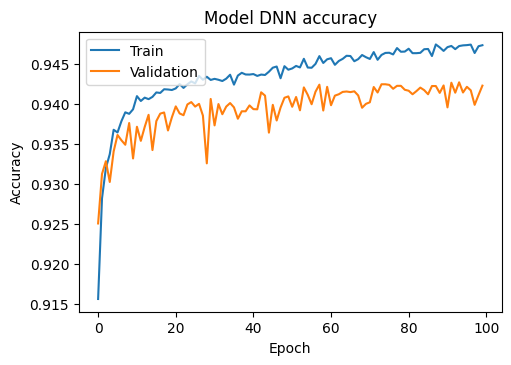

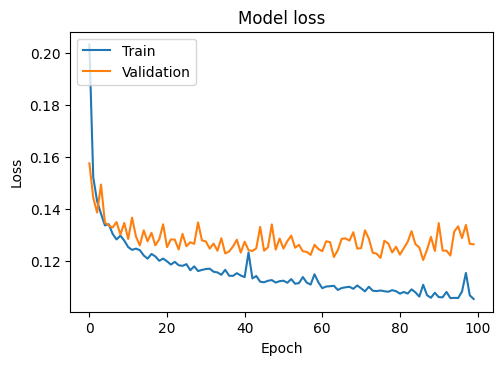

In [26]:
# Plot training & validation accuracy values

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model DNN accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Let`s evaluate the model with the test data

In [27]:
test_data = test_model.copy()

Xtest, ytest = test_data.iloc[:, :-1], test_data.iloc[:, -1]

In [28]:
test_loss, test_acc = model.evaluate(Xtest, ytest)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

5480/5480 [==============================] - 12s 2ms/step - loss: 0.1076 - accuracy: 0.9457
Test loss: 0.10762681812047958
Test accuracy: 0.9456544518470764


In [38]:
predict_DNN = model.predict(Xtest)
predict_DNN = np.argmax(predict_DNN, axis = 1)

5480/5480 [==============================] - 8s 1ms/step


In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
print(classification_report(ytest, predict_DNN))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     56000
           1       0.98      0.94      0.96    119341

    accuracy                           0.95    175341
   macro avg       0.93      0.95      0.94    175341
weighted avg       0.95      0.95      0.95    175341



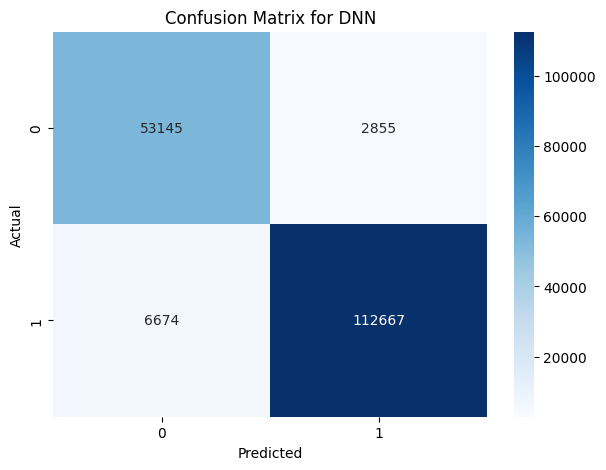

In [42]:
matrix_dnn = confusion_matrix(ytest, predict_DNN)
plt.figure(figsize = (7,5))

# Create Confusion Matrix
b = sns.heatmap(matrix_dnn, annot=True,fmt="d",cmap='Blues')

# Set the Title
b.set(title='Confusion Matrix for DNN')

# Set the Labels
b.set(xlabel='Predicted', ylabel='Actual')

# Display the Confusion Matrix
plt.show()

# MLP Model

In [ ]:
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from keras.layers import Activation, Dense

In [ ]:
modelMLP = MLPClassifier(
    solver='adam', 
    activation='logistic', 
    hidden_layer_sizes=(256,),
    learning_rate='constant', 
    max_iter=2000,
    random_state=37
)

start_time = time()
modelMLP.fit(X_train, y_train)
print('Multilayer Perceptron model trained in', round(time() - start_time, 0), 's')

Multilayer Perceptron model trained in 371.0 s


In [ ]:
predict_MLP = modelMLP.predict(Xtest)

In [ ]:
from sklearn.metrics import accuracy_score
acc_MLP = accuracy_score(ytest, predict_MLP)
print("Accuracy: {:.2f}%".format(acc_MLP * 100))

Accuracy: 93.92%


In [ ]:
MLP_matrix = confusion_matrix(ytest, predict_MLP)

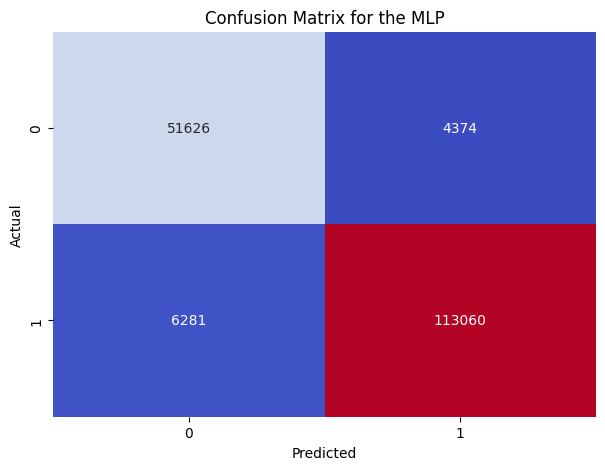

In [ ]:
plt.figure(figsize = (7,5))
c= sns.heatmap(MLP_matrix, annot=True, fmt="d",cbar=False, cmap="coolwarm")

# Set the Title
c.set(title='Confusion Matrix for the MLP')

# Set the Labels
c.set(xlabel='Predicted', ylabel='Actual')

# Display the Confusion Matrix
plt.show()

In [ ]:
# show a classification report
print(classification_report(ytest, predict_MLP))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91     56000
           1       0.96      0.95      0.95    119341

    accuracy                           0.94    175341
   macro avg       0.93      0.93      0.93    175341
weighted avg       0.94      0.94      0.94    175341



# CNN model

In [32]:
# Define the CNN model
model_cnn = Sequential()
model_cnn.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model_cnn.add(MaxPooling1D(pool_size=1))
model_cnn.add(Conv1D(64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], 1)))
model_cnn.add(MaxPooling1D(pool_size=1))
model_cnn.add(Conv1D(128, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], 1)))
model_cnn.add(MaxPooling1D(pool_size=1))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(2, activation='sigmoid'))




# Compile the model with sparse categorical cross-entropy loss
model_cnn.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn = model_cnn.fit(
    X_train,
    y_train,
    epochs=170, 
    batch_size=64, 
    callbacks=early_stop,
    validation_data=(X_test, y_test),
    verbose=1)

Epoch 1/170
1488/1488 [==============================] - 14s 5ms/step - loss: 0.1889 - accuracy: 0.9175 - val_loss: 0.1473 - val_accuracy: 0.9307
Epoch 2/170
1488/1488 [==============================] - 7s 4ms/step - loss: 0.1414 - accuracy: 0.9338 - val_loss: 0.1397 - val_accuracy: 0.9321
Epoch 3/170
1488/1488 [==============================] - 7s 5ms/step - loss: 0.1346 - accuracy: 0.9349 - val_loss: 0.1363 - val_accuracy: 0.9337
Epoch 4/170
1488/1488 [==============================] - 7s 4ms/step - loss: 0.1316 - accuracy: 0.9360 - val_loss: 0.1343 - val_accuracy: 0.9349
Epoch 5/170
1488/1488 [==============================] - 7s 5ms/step - loss: 0.1288 - accuracy: 0.9375 - val_loss: 0.1363 - val_accuracy: 0.9321
Epoch 6/170
1488/1488 [==============================] - 7s 4ms/step - loss: 0.1277 - accuracy: 0.9376 - val_loss: 0.1317 - val_accuracy: 0.9367
Epoch 7/170
1488/1488 [==============================] - 7s 5ms/step - loss: 0.1265 - accuracy: 0.9381 - val_loss: 0.1285 - val_a

In [ ]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 32)             128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 32)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 64)             2112      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 9, 64)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 9, 128)            8320      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 9, 128)           0

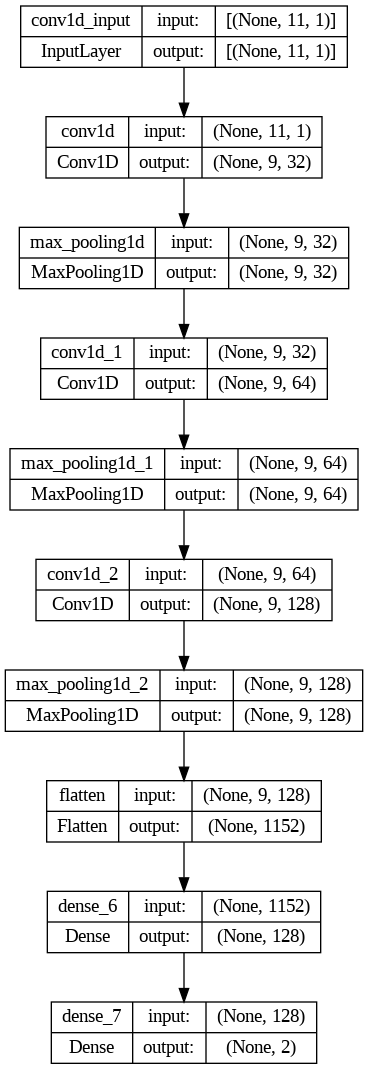

In [ ]:
plot_model(model_cnn, to_file= 'model_cnnn.png', show_shapes=True)

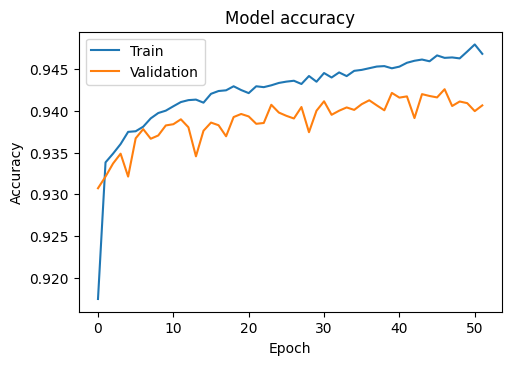

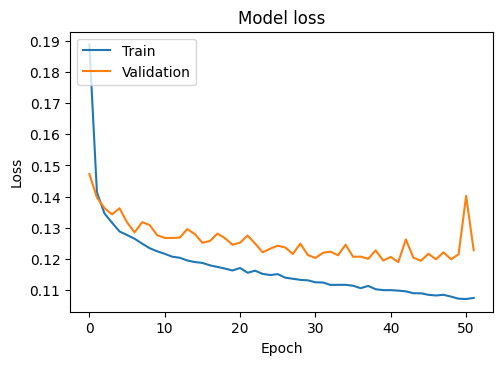

In [33]:
# Plot training & validation accuracy values

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
# Plot training & validation loss values
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model Evaluation

In [34]:
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(Xtest, ytest)
print('Test loss:', test_loss_cnn)
print('Test accuracy:', test_acc_cnn)

5480/5480 [==============================] - 12s 2ms/step - loss: 0.1060 - accuracy: 0.9486
Test loss: 0.10596998035907745
Test accuracy: 0.9485973119735718


In [35]:
predict_cnn = model_cnn.predict(Xtest)
predict_cnn = np.argmax(predict_cnn, axis = 1)

5480/5480 [==============================] - 9s 2ms/step


In [36]:
print(classification_report(ytest, predict_cnn))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     56000
           1       0.96      0.96      0.96    119341

    accuracy                           0.95    175341
   macro avg       0.94      0.94      0.94    175341
weighted avg       0.95      0.95      0.95    175341



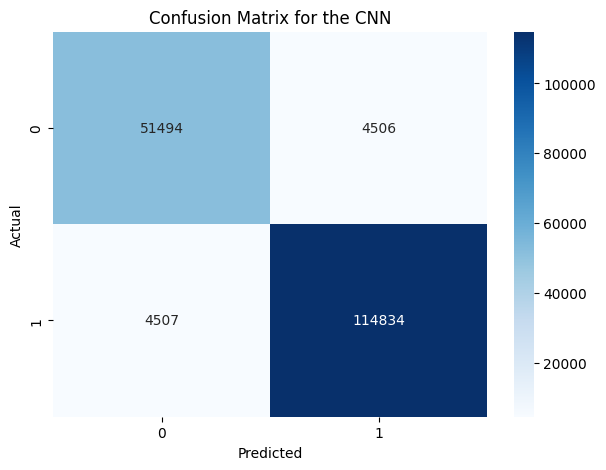

In [37]:
cm_cnn = confusion_matrix(ytest, predict_cnn)
plt.figure(figsize = (7,5))

# Create Confusion Matrix
b = sns.heatmap(cm_cnn, annot=True,fmt="d",cmap='Blues')
# Set the Title
b.set(title='Confusion Matrix for the CNN')

# Set the Labels
b.set(xlabel='Predicted', ylabel='Actual')

# Display the Confusion Matrix
plt.show()

# Build LSTM model

In [43]:
df_lstm = data_us.copy()

df_test_lstm = test_model.copy()

xtest_lstm, ytest_lstm = test_data.iloc[:, :-1], test_data.iloc[:, -1]

In [44]:
X = df_lstm.iloc[:, :-1].values
y = df_lstm.iloc[:, -1].values

xtest_lstm = np.array(xtest_lstm)
ytest_lstm = np.array(ytest_lstm)
xtest_lstm = xtest_lstm[:,1:]

X = X[: , 1:]

In [45]:
# Reshape data for LSTM
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

xtest_lstm = np.reshape(xtest_lstm, (xtest_lstm.shape[0], 1, xtest_lstm.shape[1]))
ytest_lstm = ytest_lstm.reshape(-1, 1)

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

# Build LSTM model
import keras
from keras import initializers
model_lstm = Sequential()
model_lstm.add(LSTM(units=128, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=True, kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal', bias_initializer='zeros'))

model_lstm.add(LSTM(units=128, activation='relu',return_sequences=True, kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal', bias_initializer='zeros'))

model_lstm.add(LSTM(units=128, activation='relu',kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal', bias_initializer='zeros'))

model_lstm.add(Dense(units=2, activation='sigmoid'))

In [ ]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            71168     
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_8 (Dense)             (None, 2)                 258       
                                                                 
Total params: 334,594
Trainable params: 334,594
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plot_model(model_lstm, to_file= 'model_lstm.png', show_shapes=True)
# Save the model to a file
model.save('model_lstm.h5')

Compile the model

In [47]:
model_lstm.compile(keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Fit the model

In [ ]:
# Train model
history_lstm = model_lstm.fit(X_train, 
                    Y_train, 
                    epochs=100, 
                    batch_size=64, 
                    validation_data = (X_test,Y_test)
                   )

Epoch 1/100
1488/1488 [==============================] - 19s 11ms/step - loss: 0.2440 - accuracy: 0.8942 - val_loss: 0.1766 - val_accuracy: 0.9192
Epoch 2/100
1488/1488 [==============================] - 17s 11ms/step - loss: 0.1604 - accuracy: 0.9256 - val_loss: 0.1504 - val_accuracy: 0.9308
Epoch 3/100
1488/1488 [==============================] - 17s 12ms/step - loss: 0.1488 - accuracy: 0.9289 - val_loss: 0.1448 - val_accuracy: 0.9343
Epoch 4/100
1488/1488 [==============================] - 16s 11ms/step - loss: 0.1449 - accuracy: 0.9307 - val_loss: 0.1379 - val_accuracy: 0.9348
Epoch 5/100
1488/1488 [==============================] - 16s 11ms/step - loss: 0.1413 - accuracy: 0.9323 - val_loss: 0.1363 - val_accuracy: 0.9373
Epoch 6/100
1488/1488 [==============================] - 17s 11ms/step - loss: 0.1387 - accuracy: 0.9336 - val_loss: 0.1375 - val_accuracy: 0.9366
Epoch 7/100
1488/1488 [==============================] - 16s 11ms/step - loss: 0.1366 - accuracy: 0.9341 - val_loss: 0

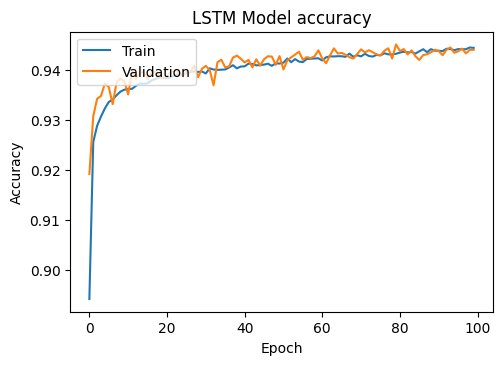

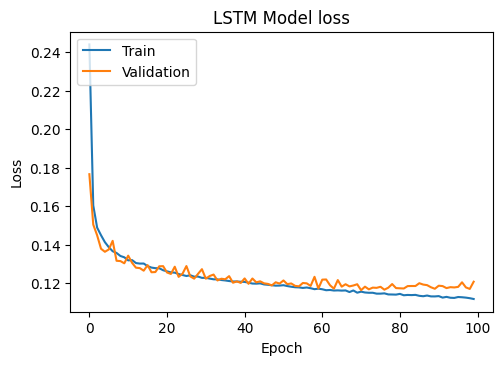

In [ ]:
# Plot training & validation accuracy values

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('LSTM Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 2)
# Plot training & validation loss values
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('LSTM Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_loss_LSTM, test_acc_LSTM = model_lstm.evaluate(xtest_lstm, ytest_lstm)
print('Test loss:', test_loss_LSTM)
print('Test accuracy:', test_acc_LSTM)

5480/5480 [==============================] - 14s 3ms/step - loss: 0.1092 - accuracy: 0.9467
Test loss: 0.10916411876678467
Test accuracy: 0.9466924667358398


In [ ]:
predict_LSTM = model_lstm.predict(xtest_lstm)
predict_LSTM = np.argmax(predict_LSTM, axis = 1)
print(classification_report(ytest_lstm, predict_LSTM))

5480/5480 [==============================] - 11s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     56000
           1       0.97      0.96      0.96    119341

    accuracy                           0.95    175341
   macro avg       0.94      0.94      0.94    175341
weighted avg       0.95      0.95      0.95    175341



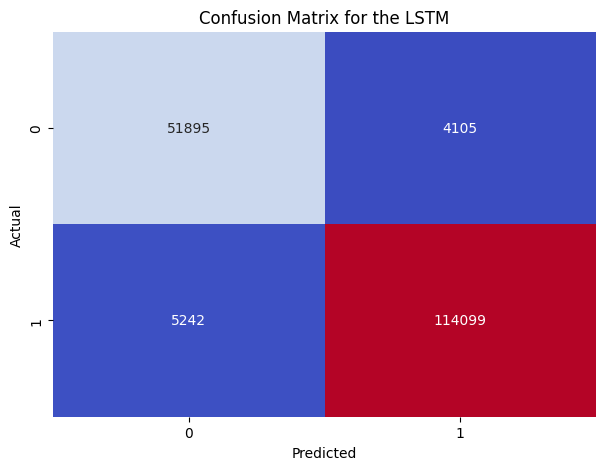

<Figure size 700x500 with 0 Axes>

In [ ]:
plt.figure(figsize = (7,5))
cm_lstm = confusion_matrix(ytest_lstm, predict_LSTM)
b=sns.heatmap(cm_lstm, annot=True, fmt="d",cbar=False, cmap="coolwarm")
plt.figure(figsize = (7,5))

# Set the Title
b.set(title='Confusion Matrix for the LSTM')

# Set the Labels
b.set(xlabel='Predicted', ylabel='Actual')

# Display the Confusion Matrix
plt.show()

Final comparing will be made with ROC Curve and AUC Score. ROC curve gives a good metric when the detection of both classes is equally important

In [ ]:
#DNN AUC
DNN_predict_probabilities = model.predict(Xtest)[:,1]

dnn_fpr, dnn_tpr, _ = roc_curve(ytest, DNN_predict_probabilities)
dnn_roc_auc = auc(dnn_fpr, dnn_tpr)

#CNN AUC
cnn_predict_probabilities = model_cnn.predict(Xtest)[:,1]
cnn_fpr, cnn_tpr, _ = roc_curve(ytest, cnn_predict_probabilities)
cnn_roc_auc = auc(cnn_fpr, cnn_tpr)

#LSTM AUC
lstm_predict_probabilities = model_lstm.predict(xtest_lstm)[:,1]
lstm_fpr, lstm_tpr, _ = roc_curve(ytest_lstm, lstm_predict_probabilities)
lstm_roc_auc = auc(lstm_fpr, lstm_tpr)



5480/5480 [==============================] - 11s 2ms/step


In [ ]:
#MLP AUC

mlp_predict_probabilities = modelMLP.predict(Xtest)
mlp_fpr, mlp_tpr, _ = roc_curve(ytest, mlp_predict_probabilities)
mlp_roc_auc = auc(mlp_fpr, mlp_tpr)

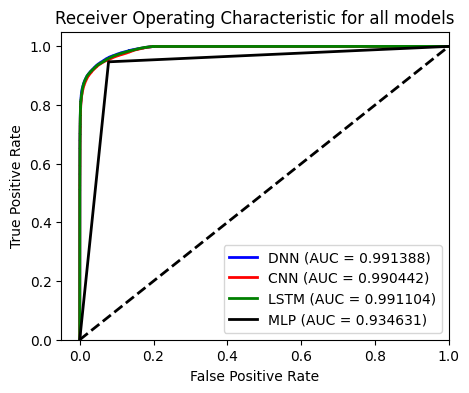

In [ ]:
plt.figure(figsize=(5, 4))
plt.title('Receiver Operating Characteristic for all models')
plt.plot(dnn_fpr, dnn_tpr, color='blue',lw=2, 
         label='DNN (AUC = %0.6f)' % dnn_roc_auc)
plt.plot(cnn_fpr, cnn_tpr, color='red',lw=2, 
         label='CNN (AUC = %0.6f)' % cnn_roc_auc)
plt.plot(lstm_fpr, lstm_tpr, color='green',lw=2, 
         label='LSTM (AUC = %0.6f)' % lstm_roc_auc)
plt.plot(mlp_fpr, mlp_tpr, color='black',lw=2, 
         label='MLP (AUC = %0.6f)' % mlp_roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.show()